# Setup COLAB

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Updating fastai...
Done.


In [ ]:
# Used to reference the root directory, for directory traversal
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Used to ignore some warnings for incompatible versions etc that spam the output
import warnings
warnings.filterwarnings("ignore")

from fastai.vision import *
from fastai.utils.mem import *

# Make destination folder for data
path_data = Path(root_dir + '/spacenet6_data')
path_data.mkdir(parents=True, exist_ok=True)
path_data

PosixPath('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data')

# Let's work only with PAN data first
Let the model learn on PAN data, then use this pretrained model for RGB, RGBNIR, PS-RGB, PS-RGBNIR, SAR-Intensity sequentially and see how that goes

# Helper functions

In [ ]:
# check out the various details of the tif file
! pip install rasterio
from rasterio.plot import show

def inspect_tif(satdat):
  # check the geospatial boundary of this image file, the corners of the image
  print("Corners: {}".format(satdat.bounds))
  print()

  # getting dimensions, in map units of meters
  width = satdat.bounds.right - satdat.bounds.left
  height = satdat.bounds.top - satdat.bounds.bottom
  print("Width: {}, Height: {}".format(width, height))
  print()

  # getting pixel dimensions
  width_px = satdat.width
  height_px = satdat.height
  print("Pixels - Width: {}, Height: {}".format(width_px, height_px))
  print()

  # how many meters to a pixel
  width_ratio = width/width_px
  height_ratio = height/height_px
  print("m to px Ratio - Width: {}, Height: {}".format(width_ratio, height_ratio))
  print()

  # get coordinate reference system
  print("Coordinate Reference System: {}".format(satdat.crs))
  print()

  # Get coordinates of top left and bottom right points since there is a coordinate reference system attached to this file
  topleft = satdat.transform * (0,0)
  bottomright = satdat.transform * (width, height)

  print("Top left coordinates: {}".format(topleft))
  print("Bottom right coordinates: {}".format(bottomright))
  print()

  # get basic metadata of this geotif file
  print("Metadata of geotiff file")
  print(satdat.meta)
  print()
  # can also use satdat.profile

  # get number of bands by listing indices. count in the metadata refers to the number of bands
  print("Indexes: {}".format(satdat.indexes))
  print()

  # default view of the tif file
  print("Default view of tif file - for verification only")
  show(satdat)

In [ ]:
# used to inspect a specific band

def inspect_band(band):
  # check the data type. We expect a numpy.ndarray
  print("Data type: {}".format(type(band)))

  # check the shape of the data, we expect 900x900 pixels for all images regardless of type
  print("Shape: {}".format(band.shape))

  # check dimensions. we expect 2 dimensions for a single band
  print("Dimensions: {}".format(band.ndim))

  # print out the band for sanity check
  print("Data: ")
  print(band)

In [ ]:
# used to visually display band data in images
from matplotlib import pyplot as plt

# mass plot all four bands
# example of input
    # bands: [red, green, blue, nir]
    # band_names: ['red', 'green', 'blue', 'nir']
    # cmaps: ['inferno', 'gist_earth', 'ocean', 'winter']
def plot_bands(bands, band_names, cmaps):
  fig = plt.figure(figsize=(16, 16))

  n = len(bands)

  for x in range(n):
    fig.add_subplot(2,2,x+1)
    plt.imshow(bands[x])

    if cmaps[x] != '': 
      plt.set_cmap(cmaps[x])
    plt.colorbar()
    plt.axis('off')
    plt.title(band_names[x])

  plt.show()

In [ ]:
# generate label image file from geojson + tif

# using a mask to cut raster along boundary
! pip install fiona
import fiona
from rasterio.mask import mask


# x in a running index
def generate_label(x):
  with fiona.open(path_geojson/fnames_geojson[x]) as f:
    aoi = [feature['geometry'] for feature in f] 

  # crop=True crops the resulting raster to the AOI's bounding box
  with rasterio.open(fnames_img[x]) as img:
    if aoi == []: 
      # there is no building in the image
      clipped = np.zeros((1,900,900), dtype=np.uint16)
      transform = img.transform
    else:
      clipped, transform = mask(img, aoi, crop=False)

  # edit the pixel values to max 255 as a mask - not sure if this is correct
  clipped[clipped > 0] = 255

  # use the metadata from the original image
  meta = img.meta.copy()

  # update metadata with new clipped boundary
  meta.update({"transform": transform,
              "height": clipped.shape[1],
              "width": clipped.shape[2]
              })

  # write the clipped-and-cropped data to a new geotiff
  fname = fnames_geojson[x][:-8] + '.tif'

  with rasterio.open(path_lbl/fname, 'w', **meta) as dst:
    dst.write(clipped)
  
  # print("Generated label for image " + fnames_img[x].name + ", index " + str(x))
  

     |████████████████████████████████| 14.7MB 210kB/s 


# Bring in the image data

In [ ]:
path_img = path_data/'images'
fnames_img = get_image_files(path_img)
fnames_img.sort()
fnames_img[:3]

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data/images/SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8679.tif'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data/images/SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8681.tif'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data/images/SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8683.tif')]

### Don't run. Deal with .tif, which is the image. In this case, PAN image (1 channel only)


Corners: BoundingBox(left=592318.6201042183, bottom=5749422.410443312, right=592768.6142138068, top=5749872.4045529)

Width: 449.9941095885588, Height: 449.9941095886752

Pixels - Width: 900, Height: 900

m to px Ratio - Width: 0.49999345509839865, Height: 0.499993455098528

Coordinate Reference System: EPSG:32631

Top left coordinates: (592318.6201042183, 5749872.4045529)
Bottom right coordinates: (592543.6142138453, 5749647.410443273)

Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(0.49999345509841014, 0.0, 592318.6201042183,
       0.0, -0.49999345509841014, 5749872.4045529)}

Indexes: (1,)

Default view of tif file - for verification only


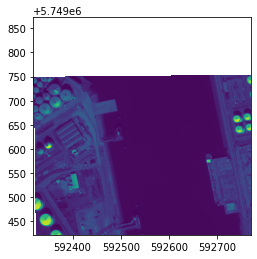

In [ ]:
import rasterio
satdat = rasterio.open(fnames_img[0])

inspect_tif(satdat)

Verify the various aspects of this PAN image

In [ ]:
pan, = satdat.read()
inspect_band(pan)

Data type: <class 'numpy.ndarray'>
Shape: (900, 900)
Dimensions: 2
Data: 
[[  0   0   0   0 ...   0   0   0   0]
 [  0   0   0   0 ...   0   0   0   0]
 [  0   0   0   0 ...   0   0   0   0]
 [  0   0   0   0 ...   0   0   0   0]
 ...
 [  0   0   0   0 ... 372 344 305 361]
 [  0   0   0   0 ... 383 359 300 363]
 [  0   0   0   0 ... 383 367 306 352]
 [  0   0   0   0 ... 363 373 309 335]]


Visually inspect the image. PAN images are black and white

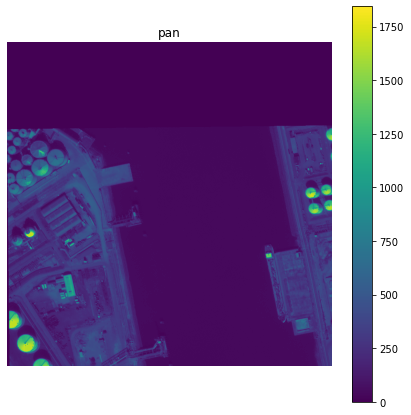

In [ ]:
plot_bands([pan], ['pan'], [''])

# Convert geojson data into image data as a mask

In [ ]:
# collect all the geojson file names as a path
import os
path_geojson = path_data/'geojson'
path_lbl = path_data/'labels'
fnames_geojson = []

for x in os.listdir(path_geojson):
  fnames_geojson.append(x)

fnames_geojson.sort()
fnames_geojson[:3]

['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.geojson',
 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.geojson',
 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.geojson']

### Don't run

In [ ]:
for x in range(len(fnames_geojson)):
  generate_label(x)

print("Labels generated")

Labels generated


In [ ]:
# using a mask to cut raster along boundary
! pip install fiona
import fiona

In [ ]:
import rasterio
from rasterio.mask import mask

with fiona.open(path_geojson/fnames_geojson[0]) as f:
  aoi = [feature['geometry'] for feature in f] 

# crop=True crops the resulting raster to the AOI's bounding box
with rasterio.open(fnames_img[0]) as img:
  if aoi == []: 
    # there is no building in the image
    clipped = np.zeros((1,900,900), dtype=np.uint16)
    transform = img.transform
  else:
    clipped, transform = mask(img, aoi, crop=False)

clipped, transform

(array([[[0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         ...,
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0]]], dtype=uint16),
 Affine(0.49999345509841014, 0.0, 592318.6201042183,
       0.0, -0.49999345509841014, 5749872.4045529))

In [ ]:
# edit the pixel values to max 255 as a mask - not sure if this is correct
clipped[clipped > 0] = 255
clipped

array([[[0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0]]], dtype=uint16)

Corners: BoundingBox(left=592318.6201042183, bottom=5749422.410443312, right=592768.6142138068, top=5749872.4045529)

Width: 449.9941095885588, Height: 449.9941095886752

Pixels - Width: 900, Height: 900

m to px Ratio - Width: 0.49999345509839865, Height: 0.499993455098528

Coordinate Reference System: EPSG:32631

Top left coordinates: (592318.6201042183, 5749872.4045529)
Bottom right coordinates: (592543.6142138453, 5749647.410443273)

Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(0.49999345509841014, 0.0, 592318.6201042183,
       0.0, -0.49999345509841014, 5749872.4045529)}

Indexes: (1,)

Default view of tif file - for verification only


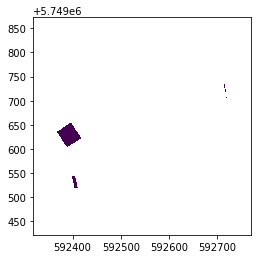

In [ ]:
# use the metadata from the original image
meta = img.meta.copy()

# update metadata with new clipped boundary
meta.update({"transform": transform,
             "height": clipped.shape[1],
             "width": clipped.shape[2]
            })

# write the clipped-and-cropped data to a new geotiff
fname = fnames_geojson[0][:-8] + '.tif'

with rasterio.open(path_lbl/fname, 'w', **meta) as dst:
  dst.write(clipped)

print("Generated label for image " + fnames_img[0].name + ", index " + str(0))  

clipped_img = rasterio.open(path_lbl/fname)
inspect_tif(clipped_img)

# Bring in the label data, which is geojson (not image)

In [ ]:
fnames_lbl = get_image_files(path_lbl)
fnames_lbl.sort()
fnames_lbl[:3]

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data/labels/SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data/labels/SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.tif'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/spacenet6_data/labels/SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.tif')]

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

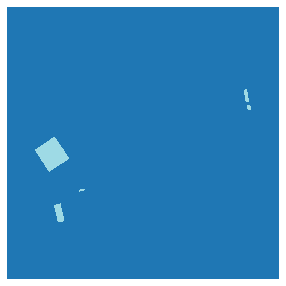

In [ ]:
mask = open_mask(get_y_fn(fnames_lbl[0]))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([900, 900]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

### Don't run

Corners: BoundingBox(left=592318.6201042183, bottom=5749422.410443312, right=592768.6142138068, top=5749872.4045529)

Width: 449.9941095885588, Height: 449.9941095886752

Pixels - Width: 900, Height: 900

m to px Ratio - Width: 0.49999345509839865, Height: 0.499993455098528

Coordinate Reference System: EPSG:32631

Top left coordinates: (592318.6201042183, 5749872.4045529)
Bottom right coordinates: (592543.6142138453, 5749647.410443273)

Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(0.49999345509841014, 0.0, 592318.6201042183,
       0.0, -0.49999345509841014, 5749872.4045529)}

Indexes: (1,)

Default view of tif file - for verification only


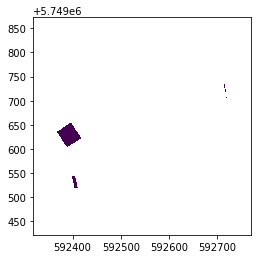

In [ ]:
maskdat = rasterio.open(fnames_lbl[0])

inspect_tif(maskdat)

In [ ]:
maskdat_arr, = maskdat.read()
# np.savetxt(path_lbl/'array.txt', mask, fmt="%s")
maskdat_arr

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint16)

# Creating codes and valid set

In [ ]:
# create codes
f = open(path_data/'codes.txt', 'w')
f.write("void\n")
f.write("building\n")
f.close()

codes = np.loadtxt(path_data/'codes.txt', dtype=str); 
codes

array(['void', 'building'], dtype='<U8')

In [ ]:
# random indexes for valid set, based on 10% of total data
valid_idx = random.sample(range(int(len(fnames_img))), int(len(fnames_img)/10))
valid_idx.sort()
print(valid_idx)
print(len(valid_idx))

[42, 53, 74, 84, 101, 103, 130, 137, 152, 153, 158, 169, 175, 176, 198, 205, 216, 224, 228, 232, 245, 247, 254, 257, 268, 306, 309, 318, 330, 338, 340, 359, 360, 366, 367, 369, 374, 389, 391, 396]
40


In [ ]:
train_idx = list(set(np.arange(len(fnames_img)))-set(valid_idx))
print(train_idx)
print(len(train_idx))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 

In [ ]:
# create valid set
f = open(path_data/'valid.txt', 'w')
for x in valid_idx:
  f.write(str(fnames_img[x].name) + '\n')
f.close()

valid = np.loadtxt(path_data/'valid.txt', dtype=str); 
print(len(valid))
valid[:3]

40


array(['SN6_Train_AOI_11_Rotterdam_PAN_20190804114132_20190804114404_tile_10821.tif',
       'SN6_Train_AOI_11_Rotterdam_PAN_20190804114647_20190804114904_tile_6255.tif',
       'SN6_Train_AOI_11_Rotterdam_PAN_20190804115211_20190804115445_tile_8041.tif'], dtype='<U75')

# Prepare the data

In [ ]:
# optimise this algo lol
train_img = []
train_lbl = []
valid_img = []
valid_lbl = []

for x in train_idx:
  # train_img.append(Image.open(fnames_img[x]))
  # train_lbl.append(Image.open(fnames_lbl[x]))
  train_img.append(np.uint8(rasterio.open(fnames_img[x]).read()))
  train_lbl.append(np.uint8(rasterio.open(fnames_lbl[x]).read()))

for x in valid_idx:
  # valid_img.append(Image.open(fnames_img[x]))
  # valid_lbl.append(Image.open(fnames_lbl[x]))
  valid_img.append(np.uint8(rasterio.open(fnames_img[x]).read()))
  valid_lbl.append(np.uint8(rasterio.open(fnames_lbl[x]).read()))

In [ ]:
class TifDataset(Dataset):
    "Sample tif array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]


In [ ]:
train_ds, valid_ds = TifDataset(train_img, train_lbl), TifDataset(valid_img, valid_lbl)
data = DataBunch.create(train_ds, valid_ds, bs=2, num_workers=1)
data.one_batch()

(tensor([[[[  0,   0,   0,  ...,   0,   0,   0],
           [  0,   0,   0,  ...,   0,   0,   0],
           [  0,   0,   0,  ...,   0,   0,   0],
           ...,
           [ 99,  96, 110,  ..., 191, 192, 206],
           [129, 132, 152,  ..., 203, 189, 198],
           [116,  96,  91,  ..., 213, 207, 226]]],
 
 
         [[[ 54,  56,  64,  ...,  47,  57,  57],
           [ 60,  55,  60,  ...,  54,  55,  54],
           [ 61,  59,  55,  ...,  60,  49,  55],
           ...,
           [  0,   0,   0,  ...,   0,   0,   0],
           [  0,   0,   0,  ...,   0,   0,   0],
           [  0,   0,   0,  ...,   0,   0,   0]]]], dtype=torch.uint8),
 tensor([[[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]],
 
 
         [[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 

In [ ]:
unet_learner(data=data, arch=models.resnet34)

TypeError: ignored

# Databunch

Use fastai defaults first

In [ ]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11128MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file(path_data/'valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

ValueError: ignored

In [ ]:
# data.show_batch(2, figsize=(10,7))

In [ ]:
# data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

In [ ]:
# name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()    

In [ ]:
# metrics=acc_camvid

In [ ]:
# wd=1e-2

In [ ]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


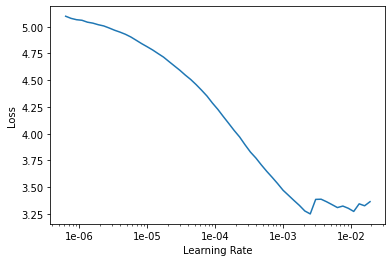

In [ ]:
# lr_find(learn)
# learn.recorder.plot()

In [ ]:
# lr=3e-3

In [ ]:
# learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.296358,0.903201,0.768188,03:19
1,0.847511,0.585227,0.845087,03:15
2,0.714124,0.584650,0.842954,03:15
3,0.652561,0.795221,0.824355,03:14
4,0.712535,0.621120,0.838964,03:13
5,0.639581,0.488733,0.864289,03:12
6,0.589068,0.480798,0.874823,03:12
7,0.549137,0.445791,0.877461,03:11
8,0.533840,0.422707,0.885992,03:11
9,0.461319,0.350573,0.891972,03:10


# idk